In [1]:
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio import Affine
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import minimum_filter
import os
import math


In [2]:
# Change these path into the directory where you saved your DEMs

dem_2024_path = r"F:\GIS THESIS\DoD Embayed\Raster\Beach_Clip\Krakal2024.tif"
dem_2025_path = r"F:\GIS THESIS\DoD Embayed\Raster\Beach_Clip\Krakal2025.tif"

# Change into your Output folder
output_dir = r"F:\GIS THESIS\DoD Embayed\Raster\Export"
os.makedirs(output_dir, exist_ok=True)


In [4]:
# Load and Align your DEMs

with rasterio.open(dem_2024_path) as src_2024:
    dem_2024 = src_2024.read(1)
    profile_2024 = src_2024.profile
    transform_2024 = src_2024.transform
    crs_2024 = src_2024.crs

with rasterio.open(dem_2025_path) as src_2025:
    dem_2025_resampled = np.empty_like(dem_2024)
    reproject(
        source=src_2025.read(1),
        destination=dem_2025_resampled,
        src_transform=src_2025.transform,
        src_crs=src_2025.crs,
        dst_transform=transform_2024,
        dst_crs=crs_2024,
        resampling=Resampling.bilinear
    )


In [5]:
filter_size = 5  # Adjust as needed
dtm_2024_estimated = minimum_filter(dem_2024, size=filter_size)
dtm_2025_estimated = minimum_filter(dem_2025_resampled, size=filter_size)


In [7]:
## 5. Mask, Clean, and Compute DoD

nodata = profile_2024.get('nodata', None)
base_mask = ~np.isnan(dtm_2024_estimated) & ~np.isnan(dtm_2025_estimated)

# DoD (DTM 2025 - DTM 2024)
dod = np.where(base_mask, dtm_2025_estimated - dtm_2024_estimated, np.nan)

# Clean invalid extremes
valid_range_mask = (dod > -100) & (dod < 100)
dod_cleaned = np.where(base_mask & valid_range_mask, dod, np.nan)

In [8]:
# volume calculation

pixel_area = abs(transform_2024[0]) * abs(transform_2024[4])

erosion_vol = np.nansum(np.where(dod_cleaned < 0, dod_cleaned, 0)) * pixel_area
deposition_vol = np.nansum(np.where(dod_cleaned > 0, dod_cleaned, 0)) * pixel_area
net_vol = deposition_vol + erosion_vol

print(f"\n📉 Erosion Volume: {erosion_vol:.2f} m³")
print(f"📈 Deposition Volume: {deposition_vol:.2f} m³")
print(f"🔁 Net Volume Change: {net_vol:.2f} m³")



📉 Erosion Volume: -2483.99 m³
📈 Deposition Volume: 2014.47 m³
🔁 Net Volume Change: -469.52 m³


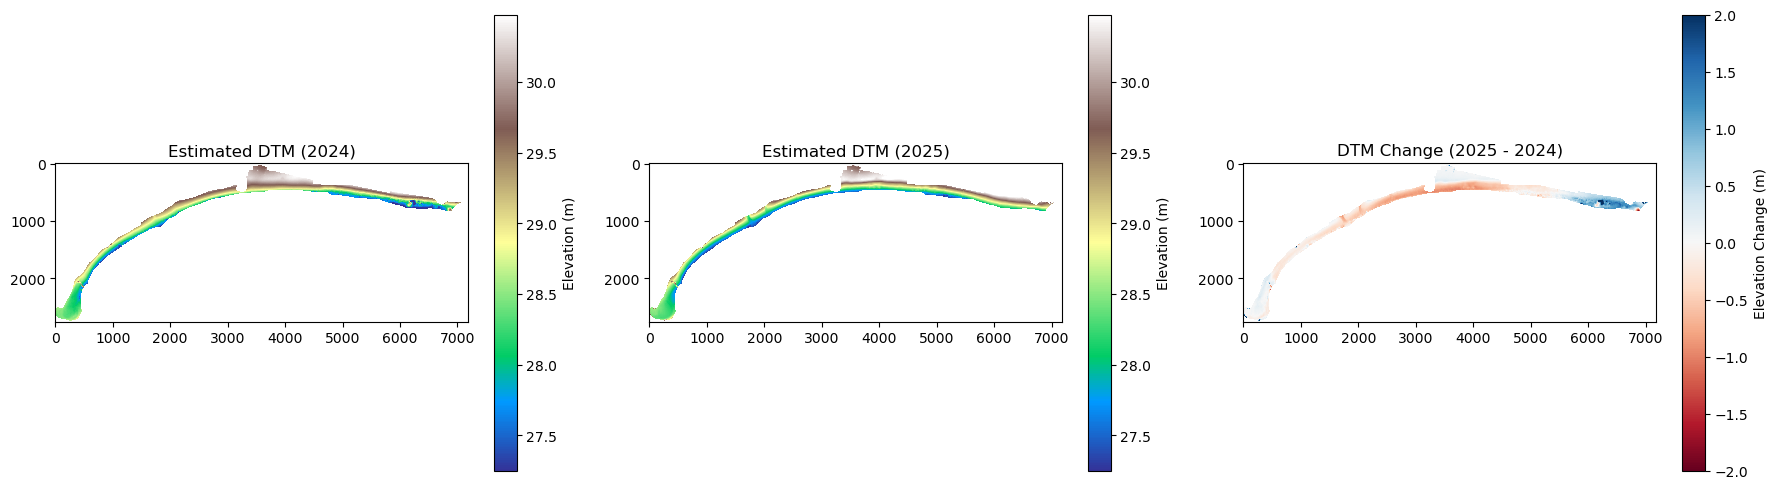

In [13]:
# visual comparison of DSM vs DTM

# --- 📊 DTM Comparison: 2024 vs 2025 (Clean Display with Masking) ---

# Mask invalid values (e.g., extreme negative filler values)
dtm_2024_valid = np.where((dtm_2024_estimated > -1000) & (dtm_2024_estimated < 1000), dtm_2024_estimated, np.nan)
dtm_2025_valid = np.where((dtm_2025_estimated > -1000) & (dtm_2025_estimated < 1000), dtm_2025_estimated, np.nan)
dtm_diff = dtm_2025_valid - dtm_2024_valid

# Use a shared color scale based on the full valid range
vmin = np.nanpercentile(np.hstack([dtm_2024_valid.flatten(), dtm_2025_valid.flatten()]), 2)
vmax = np.nanpercentile(np.hstack([dtm_2024_valid.flatten(), dtm_2025_valid.flatten()]), 98)

plt.figure(figsize=(18, 5))

# DTM 2024
plt.subplot(1, 3, 1)
plt.imshow(dtm_2024_valid, cmap='terrain', vmin=vmin, vmax=vmax)
plt.colorbar(label='Elevation (m)')
plt.title("Estimated DTM (2024)")

# DTM 2025
plt.subplot(1, 3, 2)
plt.imshow(dtm_2025_valid, cmap='terrain', vmin=vmin, vmax=vmax)
plt.colorbar(label='Elevation (m)')
plt.title("Estimated DTM (2025)")

# DTM Change
plt.subplot(1, 3, 3)
plt.imshow(dtm_diff, cmap='RdBu', vmin=-2, vmax=2)
plt.colorbar(label='Elevation Change (m)')
plt.title("DTM Change (2025 - 2024)")

plt.tight_layout()
plt.show()


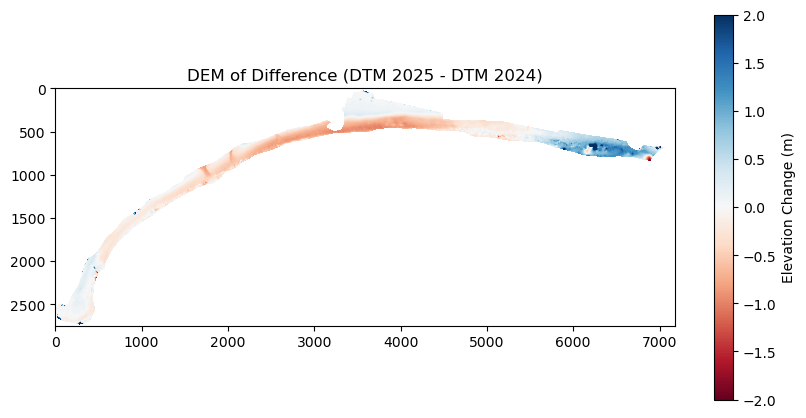

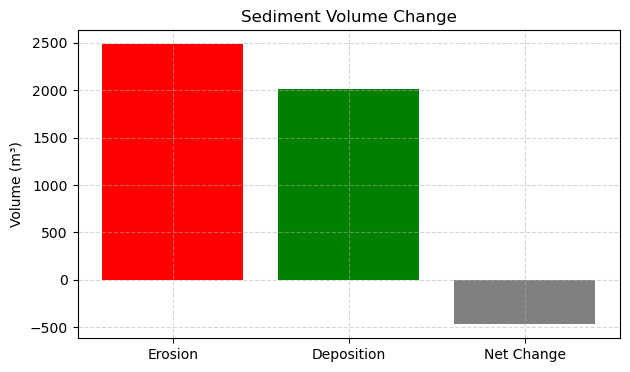

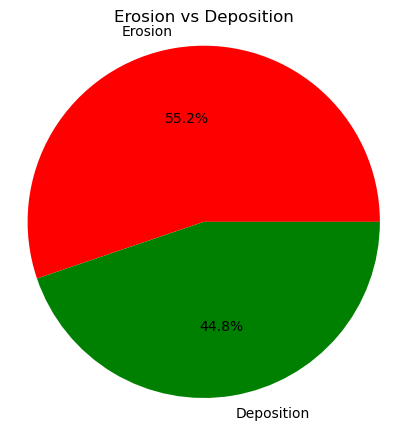

In [14]:
# DoD map
plt.figure(figsize=(10, 5))
plt.imshow(dod_cleaned, cmap='RdBu', vmin=-2, vmax=2)
plt.colorbar(label='Elevation Change (m)')
plt.title("DEM of Difference (DTM 2025 - DTM 2024)")
plt.show()

# Volume bar
plt.figure(figsize=(7, 4))
plt.bar(['Erosion', 'Deposition', 'Net Change'],
        [abs(erosion_vol), deposition_vol, net_vol],
        color=['red', 'green', 'gray'])
plt.ylabel("Volume (m³)")
plt.title("Sediment Volume Change")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Pie chart
if all(math.isfinite(v) and v > 0 for v in [abs(erosion_vol), deposition_vol]):
    plt.figure(figsize=(5, 5))
    plt.pie([abs(erosion_vol), deposition_vol],
            labels=['Erosion', 'Deposition'],
            colors=['red', 'green'],
            autopct='%1.1f%%')
    plt.title("Erosion vs Deposition")
    plt.axis('equal')
    plt.show()
else:
    print("⚠️ Pie chart skipped: Invalid volume values.")


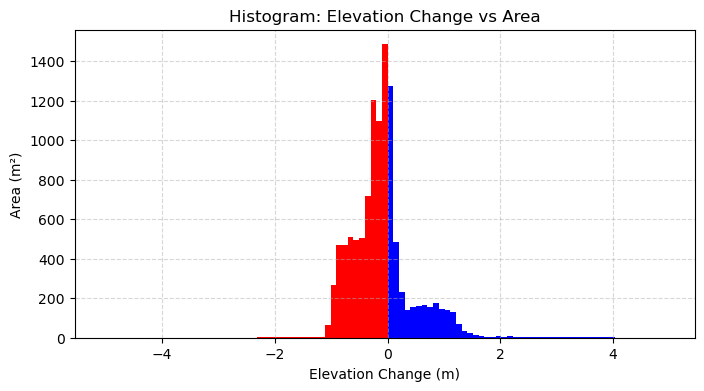

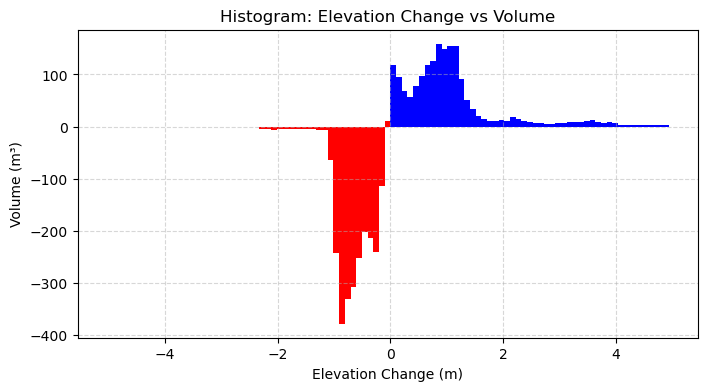

In [15]:
# Area vs Elevation
bin_edges = np.linspace(-5, 5, 100)
dod_flat = dod_cleaned[~np.isnan(dod_cleaned)]
hist_area, _ = np.histogram(dod_flat, bins=bin_edges)
area_values = hist_area * pixel_area

plt.figure(figsize=(8, 4))
plt.bar(bin_edges[:-1], area_values, width=np.diff(bin_edges),
        color=['red' if x < 0 else 'blue' for x in bin_edges[:-1]])
plt.xlabel("Elevation Change (m)")
plt.ylabel("Area (m²)")
plt.title("Histogram: Elevation Change vs Area")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Volume per bin
volume_per_bin = np.array([
    np.sum(dod_flat[(dod_flat >= bin_edges[i]) & (dod_flat < bin_edges[i+1])]) * pixel_area
    for i in range(len(bin_edges)-1)
])

plt.figure(figsize=(8, 4))
plt.bar(bin_edges[:-1], volume_per_bin, width=np.diff(bin_edges),
        color=['red' if x < 0 else 'blue' for x in bin_edges[:-1]])
plt.xlabel("Elevation Change (m)")
plt.ylabel("Volume (m³)")
plt.title("Histogram: Elevation Change vs Volume")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [16]:
output_profile = profile_2024.copy()
output_profile.update({'dtype': 'float32', 'count': 1, 'nodata': -9999})

raster_exports = {
    "Estimated_DTM_2024.tif": dtm_2024_estimated,
    "Estimated_DTM_2025.tif": dtm_2025_estimated,
    "DoD_2025_minus_2024.tif": dod_cleaned
}

for filename, data in raster_exports.items():
    path = os.path.join(output_dir, filename)
    with rasterio.open(path, 'w', **output_profile) as dst:
        dst.write(np.where(np.isnan(data), -9999, data).astype(np.float32), 1)

print("\n✅ Export complete:")
for f in raster_exports:
    print(f"- {f}")



✅ Export complete:
- Estimated_DTM_2024.tif
- Estimated_DTM_2025.tif
- DoD_2025_minus_2024.tif
